In [1]:
# Searching a motif within the mic channel of a .kwd file
# the i-th motiff is in the file pattern_i.wav
# the raw data comes in file experiment.raw.kwd

# Definitions and functions

%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.signal import hilbert
from scipy.stats import pearsonr
from scipy.io import wavfile
from scipy.signal import spectrogram
from basic_viewing import h5_functions as h5
import logging
import threading
from IPython.display import display
matplotlib.style.use('ggplot')
import yaml
import gc


class chunkFunction():
    def __init__(self, chunk, function, *args, **kwargs):
        print args
        self.chunk = chunk
        self.func = function
        self.args = args
        self.kwargs = kwargs

    def start(self):
        logger.info('Starting function {0}'.format(self.func.func_name))
#         for arg in self.args:
#             logger.debug() arg
#         for key, arg in self.kwargs.iteritems():
#             print key
#             print arg
        self.chunk.apply_filter(self.func, *self.args, **self.kwargs)
        logger.info('done')

class threadFunction():
    def __init__(self, function, *args, **kwargs):
        self.func = function
        self.args = args
        self.kwargs = kwargs
        self.out = None

    def run(self):
        logger.info('Starting function {0}'.format(self.func.func_name))
        for arg in self.args:
            print arg
        for key, arg in self.kwargs.iteritems():
            print key
            print arg
        self.out = self.func(*self.args, **self.kwargs)
        logger.info("done")

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'soundflow', 'sound_tools'))
sys.path.append(os.path.join(repos_folder, 'ephysflow'))
sys.path.append(os.path.join(repos_folder, 'analysis-tools'))

#imports after setting the paths
import soundtools as st
import Kwik as oe
from file_tools import experiment as et

def search_pattern(bird_id, sess, rec, pattern_chunk):
    logger.info('Configuring search for rec {}'.format(rec))
    fn = et.file_names(bird_id, sess, rec)
    mic_file_path = et.file_path(fn, 'ss', 'mic')
    logger.info('Loading the data from rec {}'.format(rec))
    chan_sound = st.WavData2(mic_file_path)
    logger.info('{} samples loaded'.format(chan_sound.n_samples))
    logger.info('Calling find_happy_song')
    
    exp_par = et.get_parameters(bird_id, sess, 0)
    search_pars = exp_par['search_motiff']
    cand_file_path = et.file_path(fn, 'ss', 'cand')
    cand_grp = '/pattern_{0}/{1}'.format(pattern, rec)

    candidates = st.find_happy_song(chan_sound, pattern_chunk, search_pars,
                      cand_file_path=cand_file_path,
                      cand_grp=cand_grp)
    logger.info('Found {} candidates'.format(candidates.index.size))
    return candidates

def search_pattern_all_rec(bird_id, sess, pattern_chunk):
    exp_par = et.get_parameters(bird_id, sess, 0)
    rec_list = et.get_rec_list(bird_id, sess)
    fn = et.file_names(bird_id, sess, 0)
    logger.info('Going to search for the motif in {} recs:'.format(len(rec_list)))
    rec_candidates = []
    for x in rec_list:
        rec_candidates = rec_candidates + [search_pattern(bird_id, sess, int(x), pattern_chunk)]
        gc.collect()
    return rec_candidates

#setup the data folder
ss_data_folder = os.path.join(experiment_folder, 'ss_data')

Computer: passaro


In [2]:
# User Parameters
bird_id = 'z020'
sess = 'day-sleep_remote-2016-06-05' #day of recording


# print the list of recs in the file
fn = et.file_names(bird_id, sess, 0)
sess_file_path = os.path.join(fn['folders']['ss'], fn['files']['ss_raw'])
sess_file = h5py.File(sess_file_path, 'r')
sess_file['recordings'].keys()

[u'0',
 u'1',
 u'10',
 u'100',
 u'101',
 u'102',
 u'103',
 u'104',
 u'105',
 u'106',
 u'107',
 u'108',
 u'109',
 u'11',
 u'110',
 u'111',
 u'112',
 u'113',
 u'114',
 u'115',
 u'116',
 u'117',
 u'118',
 u'119',
 u'12',
 u'120',
 u'121',
 u'122',
 u'123',
 u'124',
 u'125',
 u'126',
 u'127',
 u'128',
 u'129',
 u'13',
 u'130',
 u'131',
 u'132',
 u'133',
 u'134',
 u'135',
 u'136',
 u'137',
 u'138',
 u'139',
 u'14',
 u'140',
 u'141',
 u'142',
 u'143',
 u'144',
 u'145',
 u'146',
 u'147',
 u'148',
 u'149',
 u'15',
 u'150',
 u'151',
 u'152',
 u'153',
 u'154',
 u'155',
 u'156',
 u'157',
 u'158',
 u'159',
 u'16',
 u'160',
 u'161',
 u'162',
 u'163',
 u'164',
 u'165',
 u'166',
 u'167',
 u'168',
 u'169',
 u'17',
 u'170',
 u'171',
 u'172',
 u'173',
 u'174',
 u'18',
 u'19',
 u'2',
 u'20',
 u'21',
 u'22',
 u'23',
 u'24',
 u'25',
 u'26',
 u'27',
 u'28',
 u'29',
 u'3',
 u'30',
 u'31',
 u'32',
 u'33',
 u'34',
 u'35',
 u'36',
 u'37',
 u'38',
 u'39',
 u'4',
 u'40',
 u'41',
 u'42',
 u'43',
 u'44',
 u'45',
 u

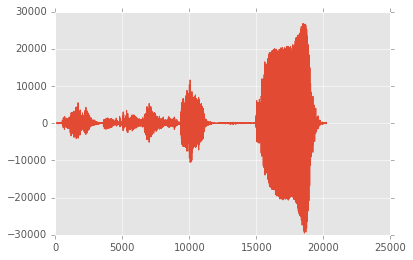

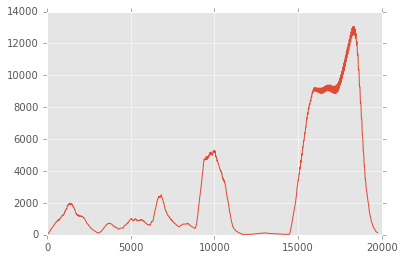

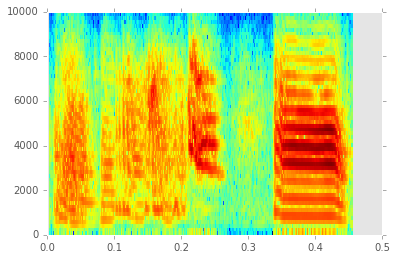

In [5]:
# prepare files for reading the stream/writing the timestamps
pattern = 1

exp_par = et.get_parameters(bird_id, sess, 0)
search_pars = exp_par['search_motiff']
cand_file_path = et.file_path(fn, 'ss', 'cand')

# get the sound and the pattern
# read a bout from a wave file and prepare the templates 
pattern_name = 'bos'
pattern_file_name = search_pars['motiff_patterns'][pattern_name]
stim_path = et.file_names(bird_id)['folders']['stim']
pattern_path = os.path.join(stim_path, pattern_file_name)

pattern_sound = st.WavData2(pattern_path)
s_f = pattern_sound.s_f

# Program parameters:
#filte
filt_lo = search_pars['filt_lo'] #Hz
filt_hi = search_pars['filt_hi'] #Hz
# sonogram 
n_window = search_pars['n_window']
n_overlap = search_pars['n_overlap']
sigma = search_pars['sigma_factor']*s_f
#template match
window_env = search_pars['window_env']

#make the filter for the data file
#The band where we expect most of the energy of zf song to be in
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')


# Plot the pattern to search
f_cut = 10000
pattern_chunk = st.Chunk(pattern_sound)
pattern_chunk.apply_filter(st.bandpass_filter, s_f)
plt.plot((pattern_chunk.data))
pattern_envelope = st.envelope(pattern_chunk.data[:,0], window=window_env)
plt.figure()
plt.plot(pattern_envelope)
pattern_spectrogram = spectrogram(pattern_chunk.data[:,0], s_f, 
                                  nperseg = n_window, 
                                  noverlap=n_overlap, 
                                  window = sg.gaussian(n_window, sigma), 
                                  scaling='spectrum')

plt.figure()
plt.pcolormesh(pattern_spectrogram[1], 
               pattern_spectrogram[0][pattern_spectrogram[0] < f_cut], 
               np.log(pattern_spectrogram[2][pattern_spectrogram[0] < f_cut, :]))

In [6]:
sess_list = ['day-sleep_remote-2016-06-05']

log_fn = et.file_names(bird_id)
log_file_path = os.path.join(log_fn['folders']['ss'], 
                             'search-motiff_{0}.log'.format(sess_list[0]))

# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_v4.210')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(threadName)-10s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

threads = []
for sess in sess_list:
    logger.info('Starting search through session {}'.format(sess))
    task_search_in_sess = threadFunction(search_pattern_all_rec, bird_id, sess, pattern_chunk)
    t = threading.Thread(name= 'search-{}'.format(sess), target=task_search_in_sess.run)
    threads.append(t)
    t.start()            
    logger.info('started')

# threads = []
# for sess in sess_list:
#     logger.info('Starting search through session {}'.sess)
#     task_search_in_sess = threadFunction(search_pattern_all_rec, bird_id, sess, pattern_chunk)
#     t = threading.Thread(name= 'task_find_happy_song', target=task_find_happy_song.run)
#     threads.append(t)
#     t.start()            
#     logger.info('started')


2016-08-03 16:27:51,194 - MainThread - INFO - Starting search through session day-sleep_remote-2016-06-05
2016-08-03 16:27:51,195 - search-day-sleep_remote-2016-06-05 - INFO - Starting function search_pattern_all_rec
2016-08-03 16:27:51,195 - MainThread - INFO - started


z020
day-sleep_remote-2016-06-05
<soundtools.Chunk instance at 0x7f575862c248>


2016-08-03 16:27:51,219 - search-day-sleep_remote-2016-06-05 - INFO - Going to search for the motif in 175 recs:
2016-08-03 16:27:51,220 - search-day-sleep_remote-2016-06-05 - INFO - Configuring search for rec 0
2016-08-03 16:27:51,223 - search-day-sleep_remote-2016-06-05 - INFO - Loading the data from rec 0
2016-08-03 16:27:51,227 - search-day-sleep_remote-2016-06-05 - INFO - 60600 samples loaded
2016-08-03 16:27:51,228 - search-day-sleep_remote-2016-06-05 - INFO - Calling find_happy_song


In [5]:
threads[1].isAlive()

True

/usr/local/anaconda/lib/python2.7/site-packages/tables/path.py:100: NaturalNameWarning: object name is not a valid Python identifier: '6'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
2016-07-26 15:49:16,989 - search-day-2016-06-29 - INFO - Found 0 candidates
2016-07-26 15:49:17,050 - search-day-2016-06-29 - INFO - Configuring search for rec 7
2016-07-26 15:49:17,053 - search-day-2016-06-29 - INFO - Loading the data from rec 7
2016-07-26 15:49:17,130 - search-day-2016-06-29 - INFO - 120073200 samples loaded
2016-07-26 15:49:17,134 - search-day-2016-06-29 - INFO - Calling find_happy_song
2016-07-26 15:53:46,505 - search-day-2016-06-24 - INFO - Found 0 candidates
2016-07-26 15:53:46,564 - search-day-2016-06-24 - INFO - Configuring search for rec 2
2016-07-26 15:53:46,569 - search-day-2016-06-24 - INFO - Loading the data from rec 2
2016-07-26 1

In [16]:
# create logger with 'spam_application'
logger = logging.getLogger('searching_motiff_v4')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - (%(threadName)-10s) - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [12]:
def open_kwd(bird, sess, location='ss'):
    fn = et.file_names(bird_id, sess, 0)
    kwd_file_file_path = et.file_path(fn, 'ss', 'ss_raw')
    kwd_file = h5py.File(kwd_file_file_path, 'r')
    return kwd_file
    
def get_rec_list(bird, sess, location='ss'):
    kwd_file = open_kwd(bird, sess, location)
    rec_list = kwd_file['/recordings'].keys()
    kwd_file.close()
    return rec_list
    
get_rec_list(bird_id, sess)

[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8']

In [12]:
spectrogram_kwargs = {'nperseg': n_window,
                      'noverlap': n_overlap,
                      'window': sg.gaussian(n_window, sigma),
                      'scaling': 'spectrum'}

In [13]:
motif_start = 0
series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
spectrogram_diff(series[:, 0],
              pattern_spectrogram[2],
              s_f,
              spectrogram_kwargs)

0.83768392395107505

In [8]:
#aftermath:
#read the result
cand_file = pd.HDFStore(cand_file_path)
result = cand_file[cand_grp]
#read the sound channel from the file
audio_slice = h5.load_table_slice(data_table, np.arange(0, data_table.shape[0]), [chan_number])
chan_sound = st.DatSoundCompat(st.bandpass_filter(audio_slice[:,0], chan_sf, filt_hi, filt_lo),
                                     chan_sf, data_type=np.float)

In [24]:
cand_file = pd.HDFStore(cand_file_path)
result = cand_file[cand_grp]

In [25]:
all_candidates = result[result['bout']==True].sort_values('spectral_diff').reset_index()
all_starts = all_candidates['start'].values
all_candidates

,index,env_corr,spectral_diff,start,bout
0,5,0.966870,0.689503,1007991,True
1,3,0.977168,0.693638,1035578,True
2,2,0.981690,0.700902,1136363,True
3,1,0.981780,0.717256,1164315,True


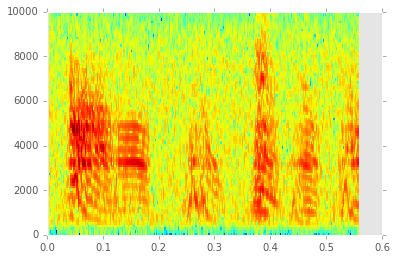

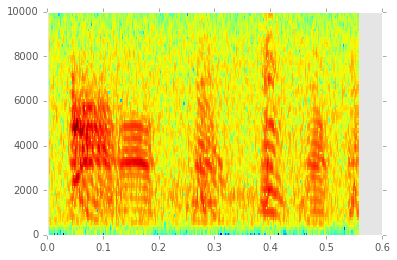

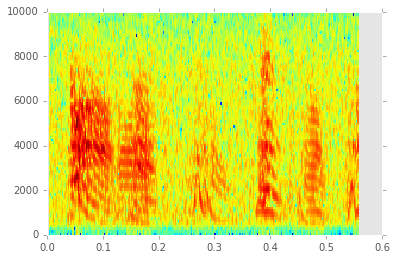

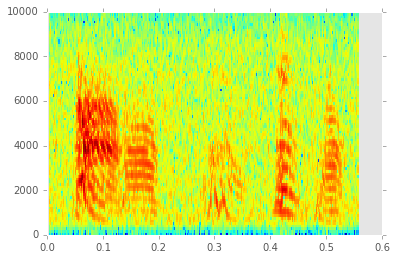

In [26]:
first_to_plot = 0
plot_as_many = 20

spectrogram_kwargs = {'nperseg': n_window,
                    'noverlap': n_overlap,
                    'window': sg.gaussian(n_window, sigma),
                    'scaling': 'spectrum'}

rms_thresh = 0.;

for (i, start) in enumerate(all_candidates['start'][first_to_plot: first_to_plot 
                                                    + plot_as_many]):
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    #print rms(st.bandpass_filter(series[:, 0], s_f))
    all_candidates.set_value(i, 'rms', st.rms(st.bandpass_filter(series[0,:], s_f)))
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

all_candidates = all_candidates[all_candidates['rms'] > rms_thresh].reset_index()

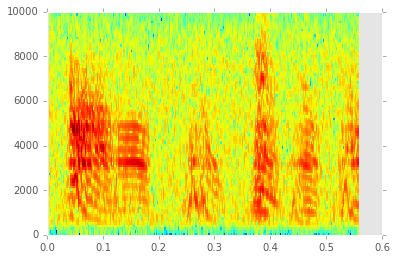

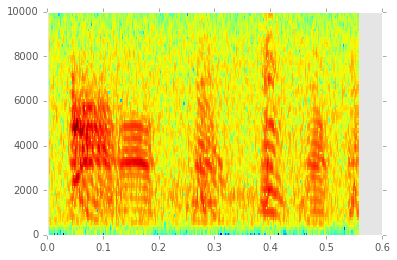

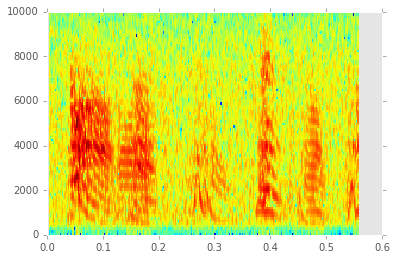

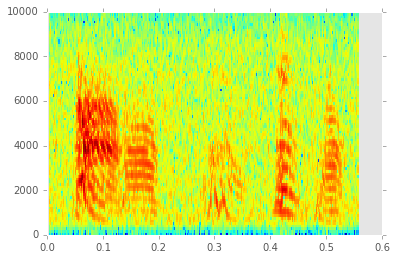

In [42]:
store_starts = np.concatenate([all_starts[:]])
store_starts

#confirm starting points
for start in store_starts:
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    sound_chunk = st.Chunk(chan_sound, segment = [motif_start, motif_start + pattern_chunk.samples])
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))

In [18]:
# Save in the file
log_file_name = 'search-motiff_{0:02}-rec_{1:03}.sav.log'.format(pattern, rec)
log_file_path = os.path.join(raw_file_folder, log_file_name)
# create logger with 'spam_application'
logger = logging.getLogger('aftermath_motiff_nopandas')
logger.setLevel(logging.DEBUG)
# create file handler which logs even debug messages
fh = logging.FileHandler(log_file_path)
fh.setLevel(logging.DEBUG)
# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
# create formatter and add it to the handlers
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)

def append_rows(table, new_data):
    rows = table.shape[0]
    more_rows = new_data.shape[0]
    table.resize(rows + more_rows, axis=0)
    if table.size == (rows + more_rows):
        table[rows:] = new_data
    else:
        table[rows:,:] = new_data

def unlimited_rows_data(group, table_name, data):
    try:
        table = group.create_dataset(table_name, 
                                     data=data, 
                                     dtype=data.dtype, 
                                     maxshape={None, None})
    except RuntimeError as e:
        if 'Name already exists' in str(e):
            table = group[table_name]
            append_rows(table, data)
        else:
            raise
    return table

def store_motiff(ev_file, rec, bout_starts, motiff_name):
    motiff_group = ev_file.require_group('/event_types/singing/{0}'.format(motiff_name))
    t_table = unlimited_rows_data(motiff_group, 'time_samples', bout_starts)
    r_table = unlimited_rows_data(motiff_group, 'recording', 
                                  data=np.ones_like(bout_starts)*int(rec))
    
mot_file_name = raw_file_base_name + '.sng.kwe'
mot_file_path = os.path.join(raw_file_folder, mot_file_name)    

logger.info('Storing {0} motiff starts in {1}'.format(store_starts.size, mot_file_name))
mot_file = h5py.File(mot_file_path, 'a')
store_motiff(mot_file, rec, store_starts, 'motiff_1')
mot_file.close()
logger.info('Success')


2016-07-10 14:08:27,026 - aftermath_motiff_nopandas - INFO - Storing 12 motiff starts in experiment.sng.kwe
2016-07-10 14:08:27,060 - aftermath_motiff_nopandas - INFO - Success


In [ ]:
def show_motiff(i):
    motif_start = start
    #print all_candidates[i]
    series = chan_sound.get_chunk(motif_start, motif_start + pattern_chunk.samples)
    # get the histogram
    f, t, sxx = spectrogram(series[0, :], s_f, **spectrogram_kwargs)
    # get the rms
    plt.figure()
    plt.pcolormesh(t, f[f < f_cut], np.log(sxx[f < f_cut, :]))